In [207]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import networkx as nx
import pylab
from tqdm import tqdm
import math

In [55]:
nodes = pd.read_csv('cleaned_top_ingreds.csv')
nodes = nodes.drop('Unnamed: 0', axis=1)
edges = pd.read_csv('filtered_pairs.csv')
edges = edges.drop('Unnamed: 0', axis=1)

In [56]:
print(nodes.shape, edges.shape)

(196, 3) (17833, 4)


In [165]:
# Generating total edge count for each ingredient

edge_count_df = edges.groupby('ingred1').agg({'counts':'sum'}).join(edges.groupby('ingred2').agg({'counts':'sum'}), lsuffix='1', rsuffix='2').fillna(0)
edge_count_df['total_edges'] = (edge_count_df['counts1'] + edge_count_df['counts2']).astype('int')
edge_count_df = edge_count_df.drop(['counts1','counts2'],axis=1)
edge_count_df.head(20)

total_edges
ingred1                           
all-purpose flour           174402
almond                       14392
almond extract                7934
apple                         7247
avocado                       9002
bacon                        16050
baking powder                68695
baking soda                  56018
balsamic vinegar             16894
banana                        5902
basil                        34375
bay leaf                     41241
beef broth                    7213
bittersweet chocolate         8581
black bean                    9774
black olive                   6580
black peppercorn             14057
blue cheese                   4404
bread crumb                  21027
brown sugar                  87258

In [59]:
# Check on total ingredients present

len(list(set(list(edges['ingred1'].unique()) + list(edges['ingred2'].unique()))))

196

## Weighting options

1. One sided ratio between two ingredients
2. inverse recipe frequency twoway (total)

In [223]:
# weight 1: one sided ratio

ratio_weights = dict.fromkeys(nodes['ingredient'].unique(), dict.fromkeys(nodes['ingredient'].unique(),0))

In [241]:
for ingred in tqdm(edge_count_df.itertuples()):
    for edge in edges.itertuples():
        if ingred[0] == edge[3]:
#             print(ingred[0], edge[4], edge[2], ingred[1], edge[2]/ingred[1])
            ratio_weights[ingred[0]][edge[4]] = edge[2] / ingred[1]
        elif ingred[0] == edge[4]:
#             print(ingred[0], edge[3], edge[2], ingred[1])
            ratio_weights[ingred[0]][edge[3]] = edge[2] / ingred[1]

196it [00:04, 48.48it/s]


In [253]:
ratio_weights_df = pd.DataFrame(list(zip(ratio_weights.keys(), ratio_weights.values())), columns = ['ingredient','weight_key'])
ratio_weights_df.head()

ingredient                                         weight_key
0     butter  {'butter': 0.026837885582280202, 'garlic': 0.0...
1     garlic  {'butter': 0.026837885582280202, 'garlic': 0.0...
2      sugar  {'butter': 0.026837885582280202, 'garlic': 0.0...
3  olive oil  {'butter': 0.026837885582280202, 'garlic': 0.0...
4        egg  {'butter': 0.026837885582280202, 'garlic': 0.0...

In [213]:
# weight 2: IF-IRF calculation

# ingredient-pair frequency - inverse recipe frequency IF-IRF
# (1 + log(1 + IF)) * log(total recipes / recipe frequency)

raw_total_recipes = 122971

for row in tqdm(edges.itertuples()):
    edges.loc[row[0],'ingred1_recipe_count'] = nodes.loc[nodes['ingredient'] == row[3], 'recipes'].item()
    edges.loc[row[0],'ingred2_recipe_count'] = nodes.loc[nodes['ingredient'] == row[4], 'recipes'].item()

edges['comb_recipe_count'] = edges['ingred1_recipe_count'] + edges['ingred2_recipe_count']

edges['counts'] = edges['counts'].astype('float64')
edges['comb_recipe_count'] = edges['comb_recipe_count'].astype('float64')

edges['IF'] = 1 + np.log10(1 + edges['counts'])
edges['IRF'] = np.log10(raw_total_recipes / edges['comb_recipe_count'])
edges['IF-IRF'] = edges['IF'] * edges['IRF']

17833it [00:31, 567.23it/s]


pairs   counts  \
0                     ('all-purpose flour', 'almond')    657.0   
1             ('all-purpose flour', 'almond extract')    634.0   
2                      ('all-purpose flour', 'apple')    356.0   
3                    ('all-purpose flour', 'avocado')     53.0   
4                      ('all-purpose flour', 'bacon')    411.0   
5              ('all-purpose flour', 'baking powder')   6721.0   
6                ('all-purpose flour', 'baking soda')   5199.0   
7           ('all-purpose flour', 'balsamic vinegar')    141.0   
8                     ('all-purpose flour', 'banana')    247.0   
9                      ('all-purpose flour', 'basil')    466.0   
10                  ('all-purpose flour', 'bay leaf')    788.0   
11                ('all-purpose flour', 'beef broth')    274.0   
12     ('all-purpose flour', 'bittersweet chocolate')    424.0   
13                ('all-purpose flour', 'black bean')     45.0   
14               ('all-purpose flour', 'black olive')     69.0   
15          ('all-purpose flour', 'black peppercorn')    171.0   
16               ('all-purpose flour', 'blue cheese')     70.0   
17               ('all-purpose flour', 'bread crumb')    647.0   
18               ('all-purpose flour', 'brown sugar')   4776.0   
19                    ('all-purpose flour', 'butter')  18382.0   
20                ('all-purpose flour', 'buttermilk')   1645.0   
21          ('all-purpose flour', 'butternut squash')     93.0   
22                ('all-purpose flour', 'cake flour')    195.0   
23                  ('all-purpose flour', 'cake mix')     58.0   
24                ('all-purpose flour', 'canola oil')    976.0   
25                     ('all-purpose flour', 'caper')    134.0   
26                    ('all-purpose flour', 'carrot')   1046.0   
27                   ('all-purpose flour', 'cayenne')    172.0   
28                    ('all-purpose flour', 'celery')    838.0   
29            ('all-purpose flour', 'cheddar cheese')    568.0   
...                                               ...      ...   
17803                  ('whole clove', 'sweet onion')      2.0   
17804                   ('whole clove', 'whole milk')     27.0   
17805                 ('whole clove', 'wine vinegar')     53.0   
17806         ('whole clove', 'worcestershire sauce')     12.0   
17807                     ('whole clove', 'zucchini')      6.0   
17808                   ('whole milk', 'feta cheese')      9.0   
17809                    ('whole milk', 'fish sauce')      1.0   
17810                 ('whole milk', 'salmon fillet')      4.0   
17811                    ('whole milk', 'sesame oil')      2.0   
17812                  ('whole milk', 'wine vinegar')     33.0   
17813          ('whole milk', 'worcestershire sauce')     64.0   
17814                      ('whole milk', 'zucchini')     14.0   
17815              ('wine vinegar', 'chocolate chip')      3.0   
17816               ('wine vinegar', 'food coloring')      1.0   
17817                  ('wine vinegar', 'shortening')      1.0   
17818        ('wine vinegar', 'worcestershire sauce')    286.0   
17819                    ('wine vinegar', 'zucchini')    134.0   
17820             ('worcestershire sauce', 'coconut')      2.0   
17821       ('worcestershire sauce', 'corn tortilla')     12.0   
17822     ('worcestershire sauce', 'dried cranberry')      4.0   
17823       ('worcestershire sauce', 'food coloring')      2.0   
17824           ('worcestershire sauce', 'ice cream')      1.0   
17825            ('worcestershire sauce', 'zucchini')     23.0   
17826                          ('zucchini', 'banana')      2.0   
17827                      ('zucchini', 'cake flour')      3.0   
17828              ('zucchini', 'confectioner sugar')     18.0   
17829                      ('zucchini', 'corn syrup')      1.0   
17830                        ('zucchini', 'ice cube')      2.0   
17831             ('zucchini', 'semisweet chocolate')      2.0   
17832                 

In [298]:
edges['loge_IF'] = 1 + np.log(1 + edges['counts'])
edges['loge_IRF'] = np.log(raw_total_recipes / edges['comb_recipe_count'])
edges['loge_IF-IRF'] = edges['loge_IF'] * edges['loge_IRF']

In [299]:
edges.sort_values(by='IF-IRF', ascending=False)

pairs  counts             ingred1  \
7257          ('coriander seed', 'cumin seed')   369.0      coriander seed   
6610         ('cinnamon stick', 'whole clove')   505.0      cinnamon stick   
7320        ('coriander seed', 'mustard seed')   175.0      coriander seed   
8544            ('cumin seed', 'mustard seed')   177.0          cumin seed   
7269         ('coriander seed', 'fennel seed')   211.0      coriander seed   
10657        ('flour tortilla', 'jack cheese')   155.0      flour tortilla   
16789           ('rice vinegar', 'sesame oil')   597.0        rice vinegar   
17001            ('sesame oil', 'sesame seed')   712.0          sesame oil   
6890            ('coconut milk', 'fish sauce')   206.0        coconut milk   
10464                 ('fish sauce', 'peanut')   109.0          fish sauce   
15178  ('mozzarella cheese', 'ricotta cheese')   260.0   mozzarella cheese   
2607    ('black peppercorn', 'coriander seed')   272.0    black peppercorn   
2742       ('black peppercorn', 'whole clove')   257.0    black peppercorn   
12422      ('ground allspice', 'ground clove')   359.0     ground allspice   
3765            ('cake flour', 'cream tartar')   136.0          cake flour   
12726        ('ground clove', 'ground ginger')   577.0        ground clove   
7663          ('corn tortilla', 'jack cheese')   123.0       corn tortilla   
16790          ('rice vinegar', 'sesame seed')   277.0        rice vinegar   
16195              ('peanut', 'peanut butter')   186.0              peanut   
10085           ('fennel bulb', 'fennel seed')   110.0         fennel bulb   
11669        ('garlic powder', 'onion powder')  1117.0       garlic powder   
8598             ('cumin seed', 'whole clove')   129.0          cumin seed   
14015               ('jalapeno', 'juice lime')   135.0            jalapeno   
6405                    ('cinnamon', 'nutmeg')   245.0            cinnamon   
9569              ('dry yeast', 'wheat flour')   155.0           dry yeast   
8495             ('cumin seed', 'fennel seed')   129.0          cumin seed   
6877          ('coconut milk', 'curry powder')   213.0        coconut milk   
5557      ('chile powder', 'ground coriander')   113.0        chile powder   
15472                   ('oat', 'wheat flour')    84.0                 oat   
5622         ('chile powder', 'spanish onion')    60.0        chile powder   
...                                        ...     ...                 ...   
16170           ('parsley', 'vanilla extract')     3.0             parsley   
3292                      ('butter', 'garlic')  8409.0              butter   
17522      ('tomato paste', 'vanilla extract')     1.0        tomato paste   
3341                   ('butter', 'olive oil')  7617.0              butter   
15652              ('olive oil', 'shortening')    13.0           olive oil   
1575                      ('banana', 'garlic')    13.0              banana   
3315                    ('butter', 'ice cube')    21.0              butter   
15730             ('onion', 'vanilla extract')    10.0               onion   
17622          ('vanilla extract', 'scallion')     1.0     vanilla extract   
11602               ('garlic', 'vanilla bean')    11.0              garlic   
3779                  ('cake flour', 'garlic')    10.0          cake flour   
17618       ('vanilla extract', 'green onion')     1.0     vanilla extract   
15620           ('olive oil', 'food coloring')     9.0           olive oil   
13665               ('ice cream', 'olive oil')    10.0           ice cream   
4740             ('celery', 'vanilla extract')     1.0              celery   
8323             ('cream tartar', 'olive oil')     8.0        cream tartar   
15682              ('onion', 'almond extract')     2.0               onion   
15728                     ('onion', 'vanilla')     2.0               onion   
15683                   ('onion', 'ice cream')     2.0               onion   
17621         ('vanilla extract', 'red onion')     1.0     vani

In [304]:
G = nx.Graph()

In [305]:
# Add edges and edge attributes
for i, elrow in edges.iterrows():
    G.add_edge(elrow[2], elrow[3], attr_dict=elrow[4:].to_dict())

In [306]:
# Add node attributes
for i, nlrow in nodes.iterrows():
    G.add_node(nlrow['ingredient'], attr_dict=nlrow[1:].to_dict())

In [307]:
recipe_count_map = [x[1]['attr_dict']['recipes'] for x in list(G.nodes(data=True))]
edge_ifirf_map = [weight[2]['attr_dict']['IF-IRF'] for weight in list(G.edges(data=True))]
edge_loge_ifirf_map = [weight[2]['attr_dict']['loge_IF-IRF'] for weight in list(G.edges(data=True))]

/Applications/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


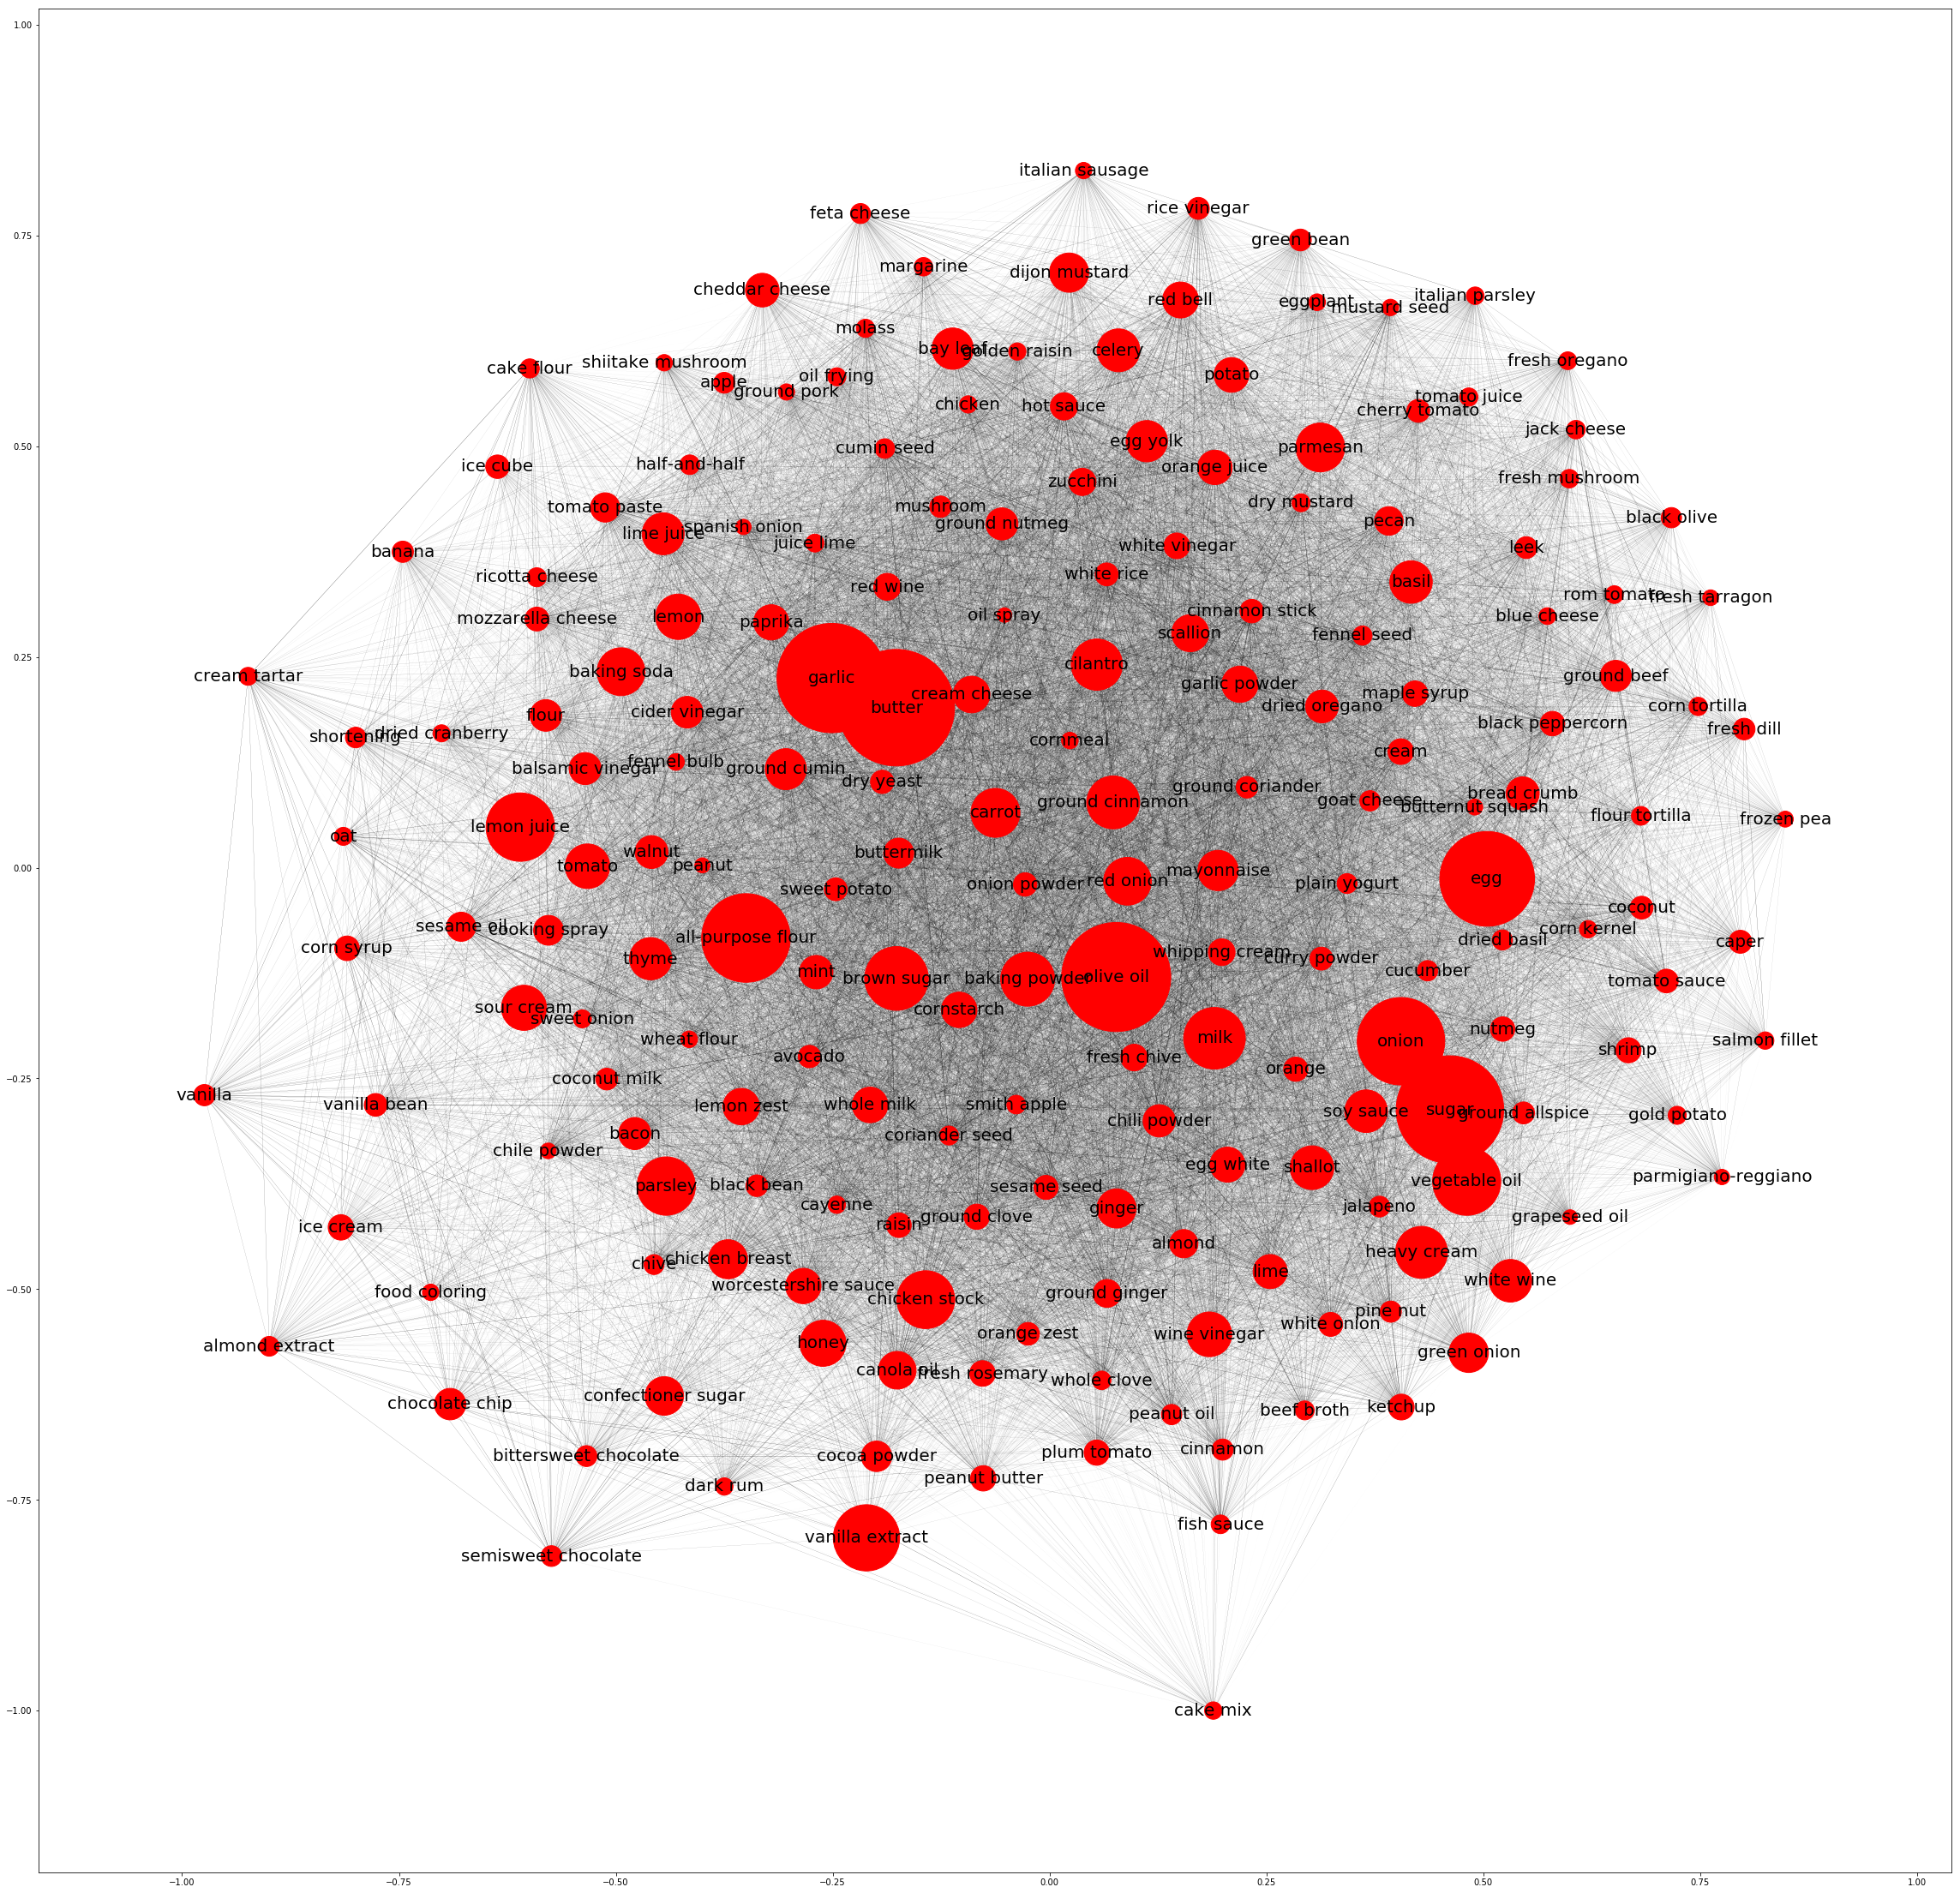

In [328]:
plt.figure(figsize=(40,40))
pos=nx.spring_layout(G, k=5/math.sqrt(G.order()))
nx.draw_networkx(G, pos, font_color='black', font_size=20, width=[math.pow(weight,3)/70000 for weight in edge_loge_ifirf_map], edge_color='black', node_size=[count/2 for count in recipe_count_map])
plt.savefig('network1_small.png', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(40,40))
pos=nx.spring_layout(G, k=1)
nx.draw_networkx(G, pos, font_color='black', font_size=20, width=0.15, edge_color='grey', node_size=[count/2 for count in recipe_count_map])

/Applications/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


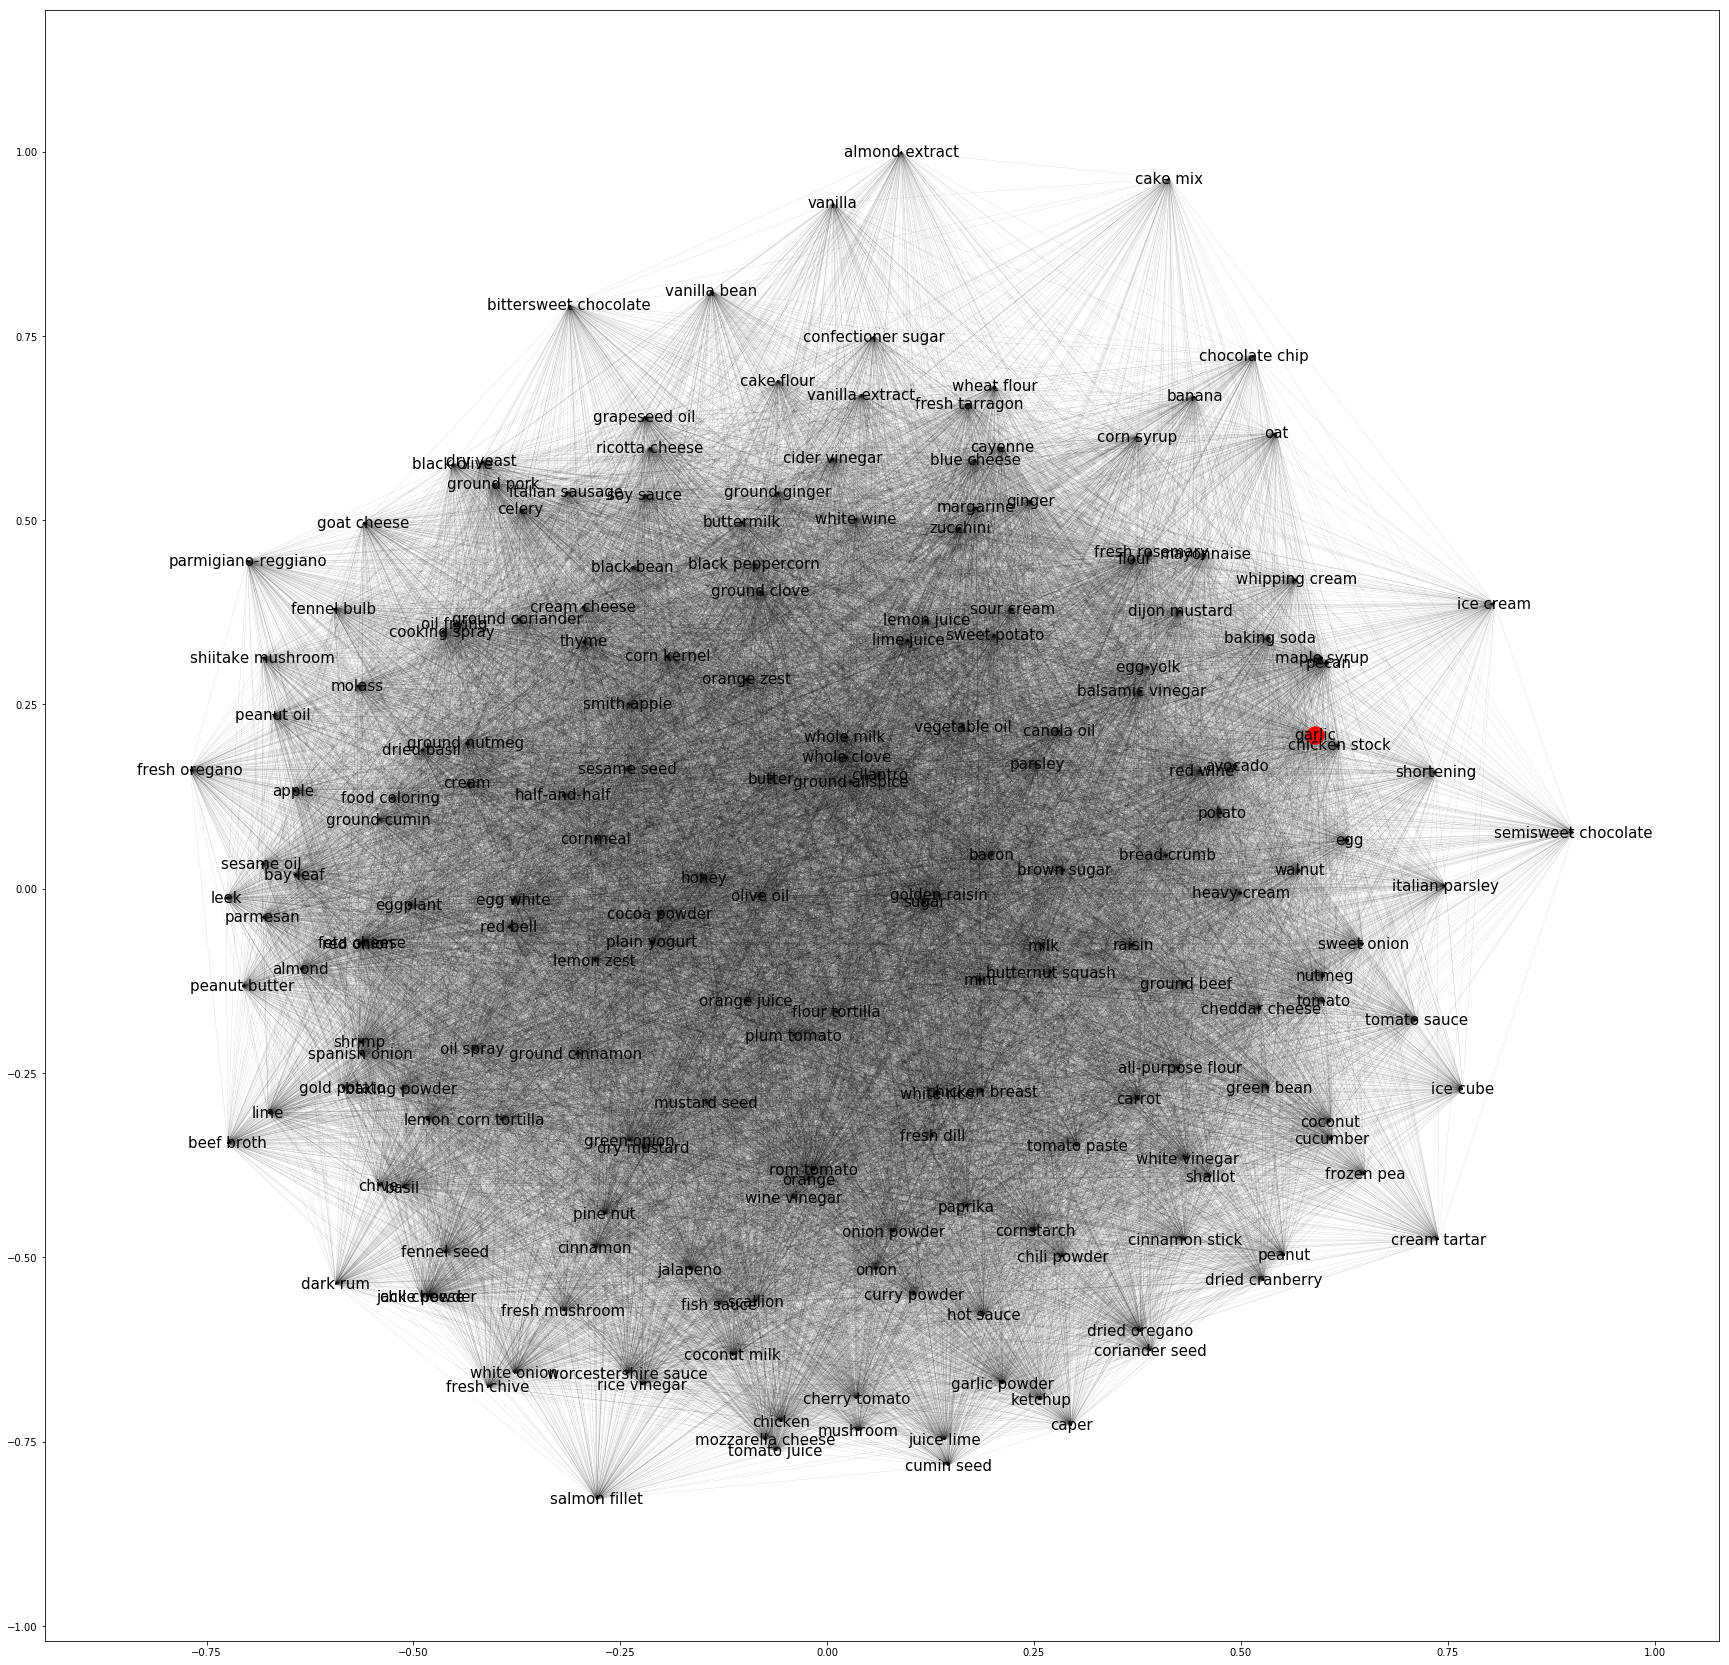

In [114]:
plt.figure(figsize=(30,30))
pos=nx.spring_layout(G)
nx.draw_networkx(G, font_color='black', font_size=15, width=0.05, nodelist=list(G.nodes())[1:2])

In [265]:
edges[['ingred1','ingred2','counts','IF','IRF','IF-IRF']].head()

ingred1         ingred2  counts        IF       IRF    IF-IRF
0  all-purpose flour          almond   657.0  3.818226  0.717517  2.739641
1  all-purpose flour  almond extract   634.0  3.802774  0.738625  2.808824
2  all-purpose flour           apple   356.0  3.552668  0.736348  2.616001
3  all-purpose flour         avocado    53.0  2.732394  0.732726  2.002096
4  all-purpose flour           bacon   411.0  3.614897  0.706167  2.552721

In [264]:
# edges[['ingred1','ingred2','counts','IF','IRF','IF-IRF']].to_csv('palladio_test.csv')

In [329]:
nx.density(G)

0.9331763474620618

In [330]:
nx.diameter(G)

2

In [331]:
nx.transitivity(G)

0.9473117462676514

In [354]:
# def common_neighbors(nodes):
    

# len(list(set((set(list(G.neighbors('oil spray'))) & set(list(G.neighbors('butter')))))))

183

In [339]:
list(G.nodes())[1]

'almond'

In [357]:
nodes.head()

ingredient   total  recipes
0     butter  421929    36975
1     garlic  384999    32539
2      sugar  383695    31492
3  olive oil  377461    32429
4        egg  257308    24435

In [365]:
edges.head(1)

pairs  counts            ingred1 ingred2  \
0  ('all-purpose flour', 'almond')   657.0  all-purpose flour  almond   

   ingred1_recipe_count  ingred2_recipe_count  comb_recipe_count        IF  \
0               21384.0                2182.0            23566.0  3.818226   

        IRF    IF-IRF   loge_IF  loge_IRF  loge_IF-IRF  
0  0.717517  2.739641  7.489205  1.652144    12.373242

In [401]:
# Preparing for json export for d3

G = nx.Graph()

In [402]:
# Add node attributes
for i, nlrow in nodes.iterrows():
    G.add_node(nlrow['ingredient'], ingred_name=nlrow['ingredient'], recipes=nlrow['recipes'], svg_link=nlrow['svg_link'])

In [403]:
# Add edges and edge attributes
for i, elrow in edges.iterrows():
    G.add_edge(elrow[2], elrow[3], edge_count = elrow['counts'], loge_ifirf = elrow['loge_IF-IRF'], log10_ifirf = elrow['IF-IRF'])

In [404]:
import json
from networkx.readwrite import json_graph

j = json_graph.node_link_data(G)
 
js = json.dumps(j, ensure_ascii=False, indent=2)
with open("node-link-value.json", "w") as file:
     file.write(js)

In [372]:
np.log(nodes['recipes']).describe()

count    196.000000
mean       7.615377
std        0.898568
min        6.356108
25%        6.892134
50%        7.370207
75%        8.153890
max       10.517997
Name: recipes, dtype: float64

In [380]:
nodes[nodes['recipes'] >= nodes['recipes'].mean()]

ingredient   total  recipes
0               butter  421929    36975
1               garlic  384999    32539
2                sugar  383695    31492
3            olive oil  377461    32429
4                  egg  257308    24435
5    all-purpose flour  239413    21384
6                onion  229482    20845
7      vanilla extract  142113    11957
8        vegetable oil  138582    12645
9          lemon juice  127903    12743
10         brown sugar  124889    11073
11       chicken stock  106570     9134
12             parsley  104942     9285
13                milk  102732    10361
14            cilantro   91487     7153
15       baking powder   89398     7949
16     ground cinnamon   87513     7652
17              carrot   83137     6529
18         heavy cream   82756     7376
19           red onion   72624     6225
20         baking soda   70784     6250
21            parmesan   66693     6492
22            bay leaf   64901     4656
23             shallot   62930     5210
24        wine vinegar   62855     5443
25               thyme   61939     4875
26               honey   61122     5787
27               lemon   59356     5608
28           soy sauce   59057     4950
29              celery   59049     5010
30              tomato   58749     5418
31          canola oil   57917     3871
32          sour cream   57765     5545
33          white wine   57486     4944
34        ground cumin   57199     4594
35            egg yolk   54312     4649
36              ginger   53734     4180
37               basil   53642     4926
38          lime juice   49923     4801
39       dijon mustard   46075     4194
40  confectioner sugar   45389     4060
41         green onion   44460     4233
42            scallion   44088     3748
43          mayonnaise   42960     4432
44            red bell   41058     3528
48          whole milk   37732     3460
49      chicken breast   37718     4161
50       garlic powder   36165     3601
53          lemon zest   34998     3629
55        cream cheese   34757     3663

In [399]:
nodes['svg_link'] = "shopping_basket.svg"
nodes.loc[nodes['ingredient'] == "butter", "svg_link"] = "butter.svg"
nodes.loc[nodes['ingredient'] == "garlic", "svg_link"] = "garlic.svg"
nodes.loc[nodes['ingredient'] == "sugar", "svg_link"] = "sugar.svg"
nodes.loc[nodes['ingredient'] == "olive oil", "svg_link"] = "olive_oil.svg"
nodes.loc[nodes['ingredient'] == "egg", "svg_link"] = "egg.svg"
nodes.loc[nodes['ingredient'] == "all-purpose flour", "svg_link"] = "flour.svg"
nodes.loc[nodes['ingredient'] == "onion", "svg_link"] = "onion.svg"
nodes.loc[nodes['ingredient'] == "vanilla extra", "svg_link"] = "vanilla.svg"
nodes.loc[nodes['ingredient'] == "vegetable oil", "svg_link"] = "vegetable_oil.svg"
nodes.loc[nodes['ingredient'] == "lemon juice", "svg_link"] = "lemon_juice.svg"



In [400]:
nodes

ingredient   total  recipes             svg_link
0                 butter  421929    36975           butter.svg
1                 garlic  384999    32539           garlic.svg
2                  sugar  383695    31492            sugar.svg
3              olive oil  377461    32429        olive_oil.svg
4                    egg  257308    24435              egg.svg
5      all-purpose flour  239413    21384            flour.svg
6                  onion  229482    20845            onion.svg
7        vanilla extract  142113    11957  shopping_basket.svg
8          vegetable oil  138582    12645    vegetable_oil.svg
9            lemon juice  127903    12743      lemon_juice.svg
10           brown sugar  124889    11073  shopping_basket.svg
11         chicken stock  106570     9134  shopping_basket.svg
12               parsley  104942     9285  shopping_basket.svg
13                  milk  102732    10361  shopping_basket.svg
14              cilantro   91487     7153  shopping_basket.svg
15         baking powder   89398     7949  shopping_basket.svg
16       ground cinnamon   87513     7652  shopping_basket.svg
17                carrot   83137     6529  shopping_basket.svg
18           heavy cream   82756     7376  shopping_basket.svg
19             red onion   72624     6225  shopping_basket.svg
20           baking soda   70784     6250  shopping_basket.svg
21              parmesan   66693     6492  shopping_basket.svg
22              bay leaf   64901     4656  shopping_basket.svg
23               shallot   62930     5210  shopping_basket.svg
24          wine vinegar   62855     5443  shopping_basket.svg
25                 thyme   61939     4875  shopping_basket.svg
26                 honey   61122     5787  shopping_basket.svg
27                 lemon   59356     5608  shopping_basket.svg
28             soy sauce   59057     4950  shopping_basket.svg
29                celery   59049     5010  shopping_basket.svg
..                   ...     ...      ...                  ...
166              chicken    5685      809  shopping_basket.svg
167              cayenne    5658      828  shopping_basket.svg
168          gold potato    5587      891  shopping_basket.svg
169          dry mustard    5423      882  shopping_basket.svg
170          smith apple    5398      948  shopping_basket.svg
171         cream tartar    5315      876  shopping_basket.svg
172    shiitake mushroom    5311      736  shopping_basket.svg
173  parmigiano-reggiano    5268      643  shopping_basket.svg
174          sweet onion    5251      883  shopping_basket.svg
175               peanut    5188      618  shopping_basket.svg
176            margarine    5109      925  shopping_basket.svg
177             cake mix    5095      825  shopping_basket.svg
178          fennel bulb    5086      763  shopping_basket.svg
179          wheat flour    5058      758  shopping_basket.svg
180        grapeseed oil    5047      585  shopping_basket.svg
181             ice cube    5033     1503  shopping_basket.svg
182        golden raisin    4968      812  shopping_basket.svg
183     butternut squash    4886      699  shopping_basket.svg
184           frozen pea    4856      695  shopping_basket.svg
185           oil frying    4832      885  shopping_basket.svg
186             dark rum    4754      820  shopping_basket.svg
187      dried cranberry    4749      791  shopping_basket.svg
188                  oat    4699      883  shopping_basket.svg
189          blue cheese    4697      770  shopping_basket.svg
190        salmon fillet    4689      823  shopping_basket.svg
191          corn kernel    4680      819  shopping_basket.svg
192       fresh tarragon    4615      674  shopping_basket.svg
193             cornmeal    4532      753  shopping_basket.svg
194       fresh mushroom    4515      933  shopping_basket.svg
195            oil spray    4485      576  shopping_basket.svg

[196 rows x 4 columns]